In [40]:
library(data.table)
library(mixOmics)
library(raster)
library(pracma)
library(ggpubr)
library(cowplot)
library(mediation)
source("./R/functions.R")

#Schizophrenia EWAS results for sites previously identified as associated with tobacco smoking
tobacco_schizo <- c("cg05575921",
                    "cg01940273",
                    "cg26703534",
                    "cg03636183",
                    "cg05951221",
                    "cg25952192",
                    "cg03274391",
                    "cg01772743",
                    "cg13862853",
                    "cg20566897")

sample_id_phase1 <- read.csv("./GEO/E-GEOD-80417.sdrf.txt",sep = "\t")
sample_id_phase2 <- read.csv("./GEO/E-GEOD-84727.sdrf.txt",sep = "\t")

phase1 <- fread("./GEO/GSE80417_normalizedBetas.csv", header = T)
phase2 <- fread("./GEO/GSE84727_normalisedBetas.csv", header = T)

common_probes <- intersect(phase1$V1,phase2$V1)
common_probes <- setdiff(common_probes,tobacco_schizo)

phase1 <- subset(phase1, V1 %in% common_probes)
phase2 <- subset(phase2, V1 %in% common_probes)

Aberdeen_covariates <- read.csv("./data_sources/AdditionalCovariatesAberdeen.csv")
UCL_covariates <- read.csv("./data_sources/AdditionalCovariatesUCL.csv")

In [2]:
CoRSIV_Probes<- read.csv("./HM450k_probe_sets/CoRSIV_ESS_SIV_CG_sites_clusters_hg38.csv",
                         header = T,stringsAsFactors = F,sep = ",")
phase1 <- subset(phase1, V1 %in% CoRSIV_Probes$CG)
phase2 <- subset(phase2, V1 %in% CoRSIV_Probes$CG)

In [3]:
colnames_phase1 <- phase1$V1
phase1$V1 <- NULL
phase1_t <- data.frame(t(phase1))
colnames(phase1_t) <- colnames_phase1
phase1_t$sample.id <- rownames(phase1_t)
rownames(phase1_t) <- NULL

In [4]:
colnames_phase2 <- phase2$V1
phase2$V1 <- NULL
phase2_t <- data.frame(t(phase2))
colnames(phase2_t) <- colnames_phase2
phase2_t$sample.id <- rownames(phase2_t)
rownames(phase2_t) <- NULL

In [5]:
#phase 2 data to train and phase 1 data to test
test <- data.frame(merge(sample_id_phase1,phase1_t,by.x = "id",by.y = "sample.id"))
train <- data.frame(merge(sample_id_phase2,phase2_t,by.x = "id",by.y = "sample.id"))

In [6]:
train <- average_corsiv_methylation(train)
test <- average_corsiv_methylation(test)

In [7]:
#build on phase 2
train$id <- NULL
train$sample_title <- NULL
train$status <- as.factor(ifelse(train$status==1,0,1))

test$id  <- NULL
test$gender <- NULL
test$age <- NULL
test$status <- as.factor(ifelse(test$status==1,0,1))

In [8]:
splsda_output_beta <- mixOmics::splsda(X = subset(train,select = -c(status)),
                                        Y = train$status,ncomp = 2,keepX=c(100,100))

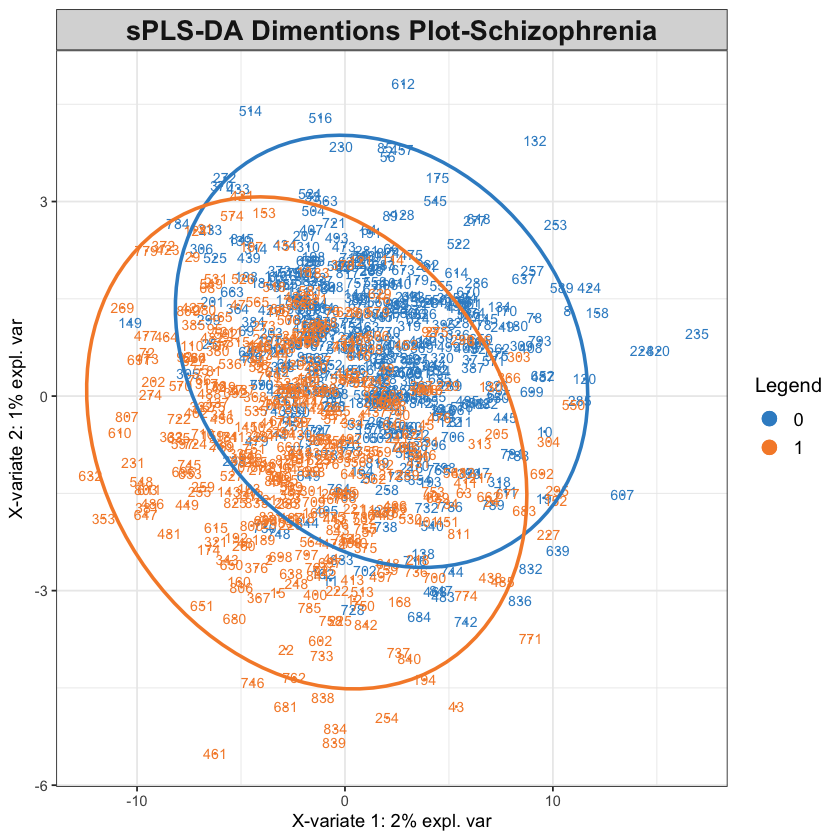

In [9]:
v <- plotIndiv(splsda_output_beta, legend=TRUE,comp = c(1,2),
               ellipse = T, star = FALSE, title = paste0('sPLS-DA Dimentions Plot-',"Schizophrenia"))

Loading required package: scales



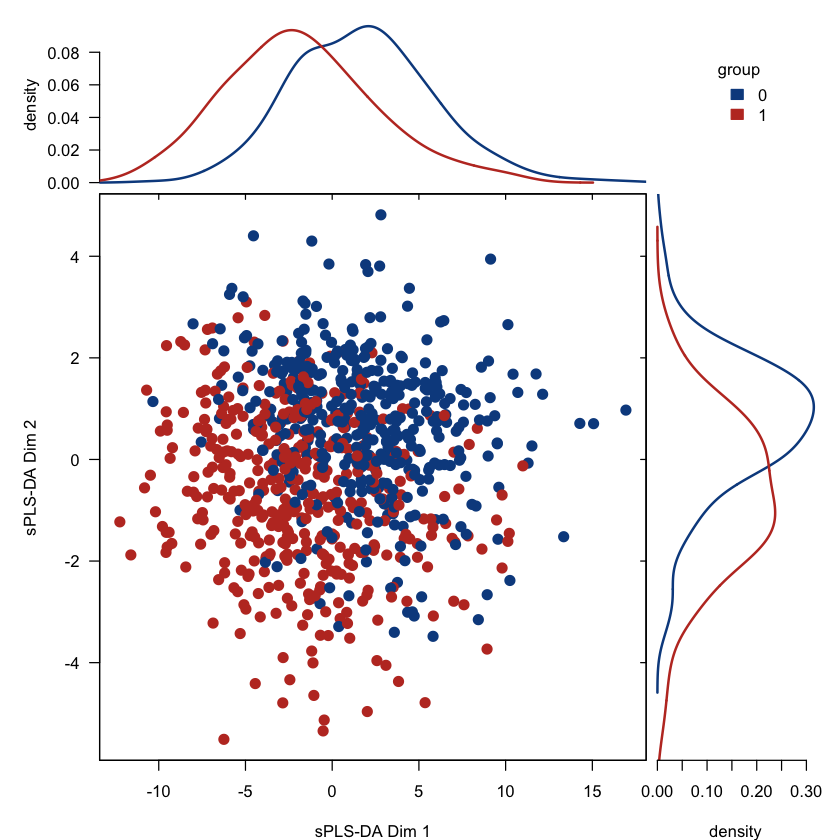

In [10]:
plsdaDF <- as.data.frame(v$df)
v$df$x <- 1*v$df$x
v$df$y <- 1*v$df$y
highest_x_y <- ceiling(max(max(abs(plsdaDF$x)),max(abs(plsdaDF$y))))
marginal_plot(x = x, y = y, group = group, data = v$df,
              bw = "nrd", lm_formula = NULL, xlab = "sPLS-DA Dim 1", ylab = "sPLS-DA Dim 2", pch = 16, cex =1.5)#,
              #xlim = c(-highest_x_y,highest_x_y),ylim= c(-highest_x_y,highest_x_y))



[1] 2.832238
[1] -1.731128


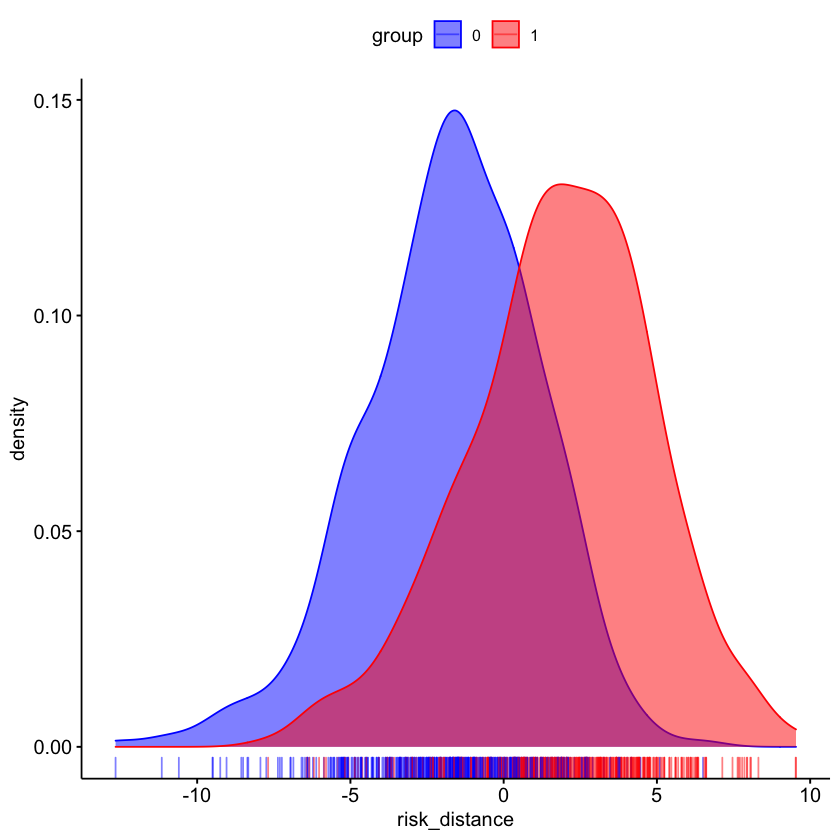

In [11]:

highest_x_y <- ceiling(max(max(abs(plsdaDF$x)),max(abs(plsdaDF$y))))
risk_distance <- function(cancer_sample){
    X <- as.numeric(cancer_sample[1])
    Y <- as.numeric(cancer_sample[2])
    d <- pointDistance(c(0,0),c(X,Y),lonlat = F)
    return(d*cos(atan2(Y,X) - deg2rad(45)))# - for MBCN + for BC
}
plsdaDF$risk_distance <- -1*apply(plsdaDF, 1, risk_distance)
plot.data <- plsdaDF[c("group","risk_distance")]

ggdensity(plot.data, x = "risk_distance",
          rug = TRUE,
          color = "group", fill = "group",
          palette = c("blue", "red"))
stdev_controls <- sd(plot.data[plot.data$group==0,]$risk_distance)#increase n
mean_controls <- mean(plot.data[plot.data$group==0,]$risk_distance)
print(stdev_controls)
print(mean_controls)

In [ ]:
Y <- test$status
test$status <- NULL
test.predict <- predict(splsda_output_beta, test)

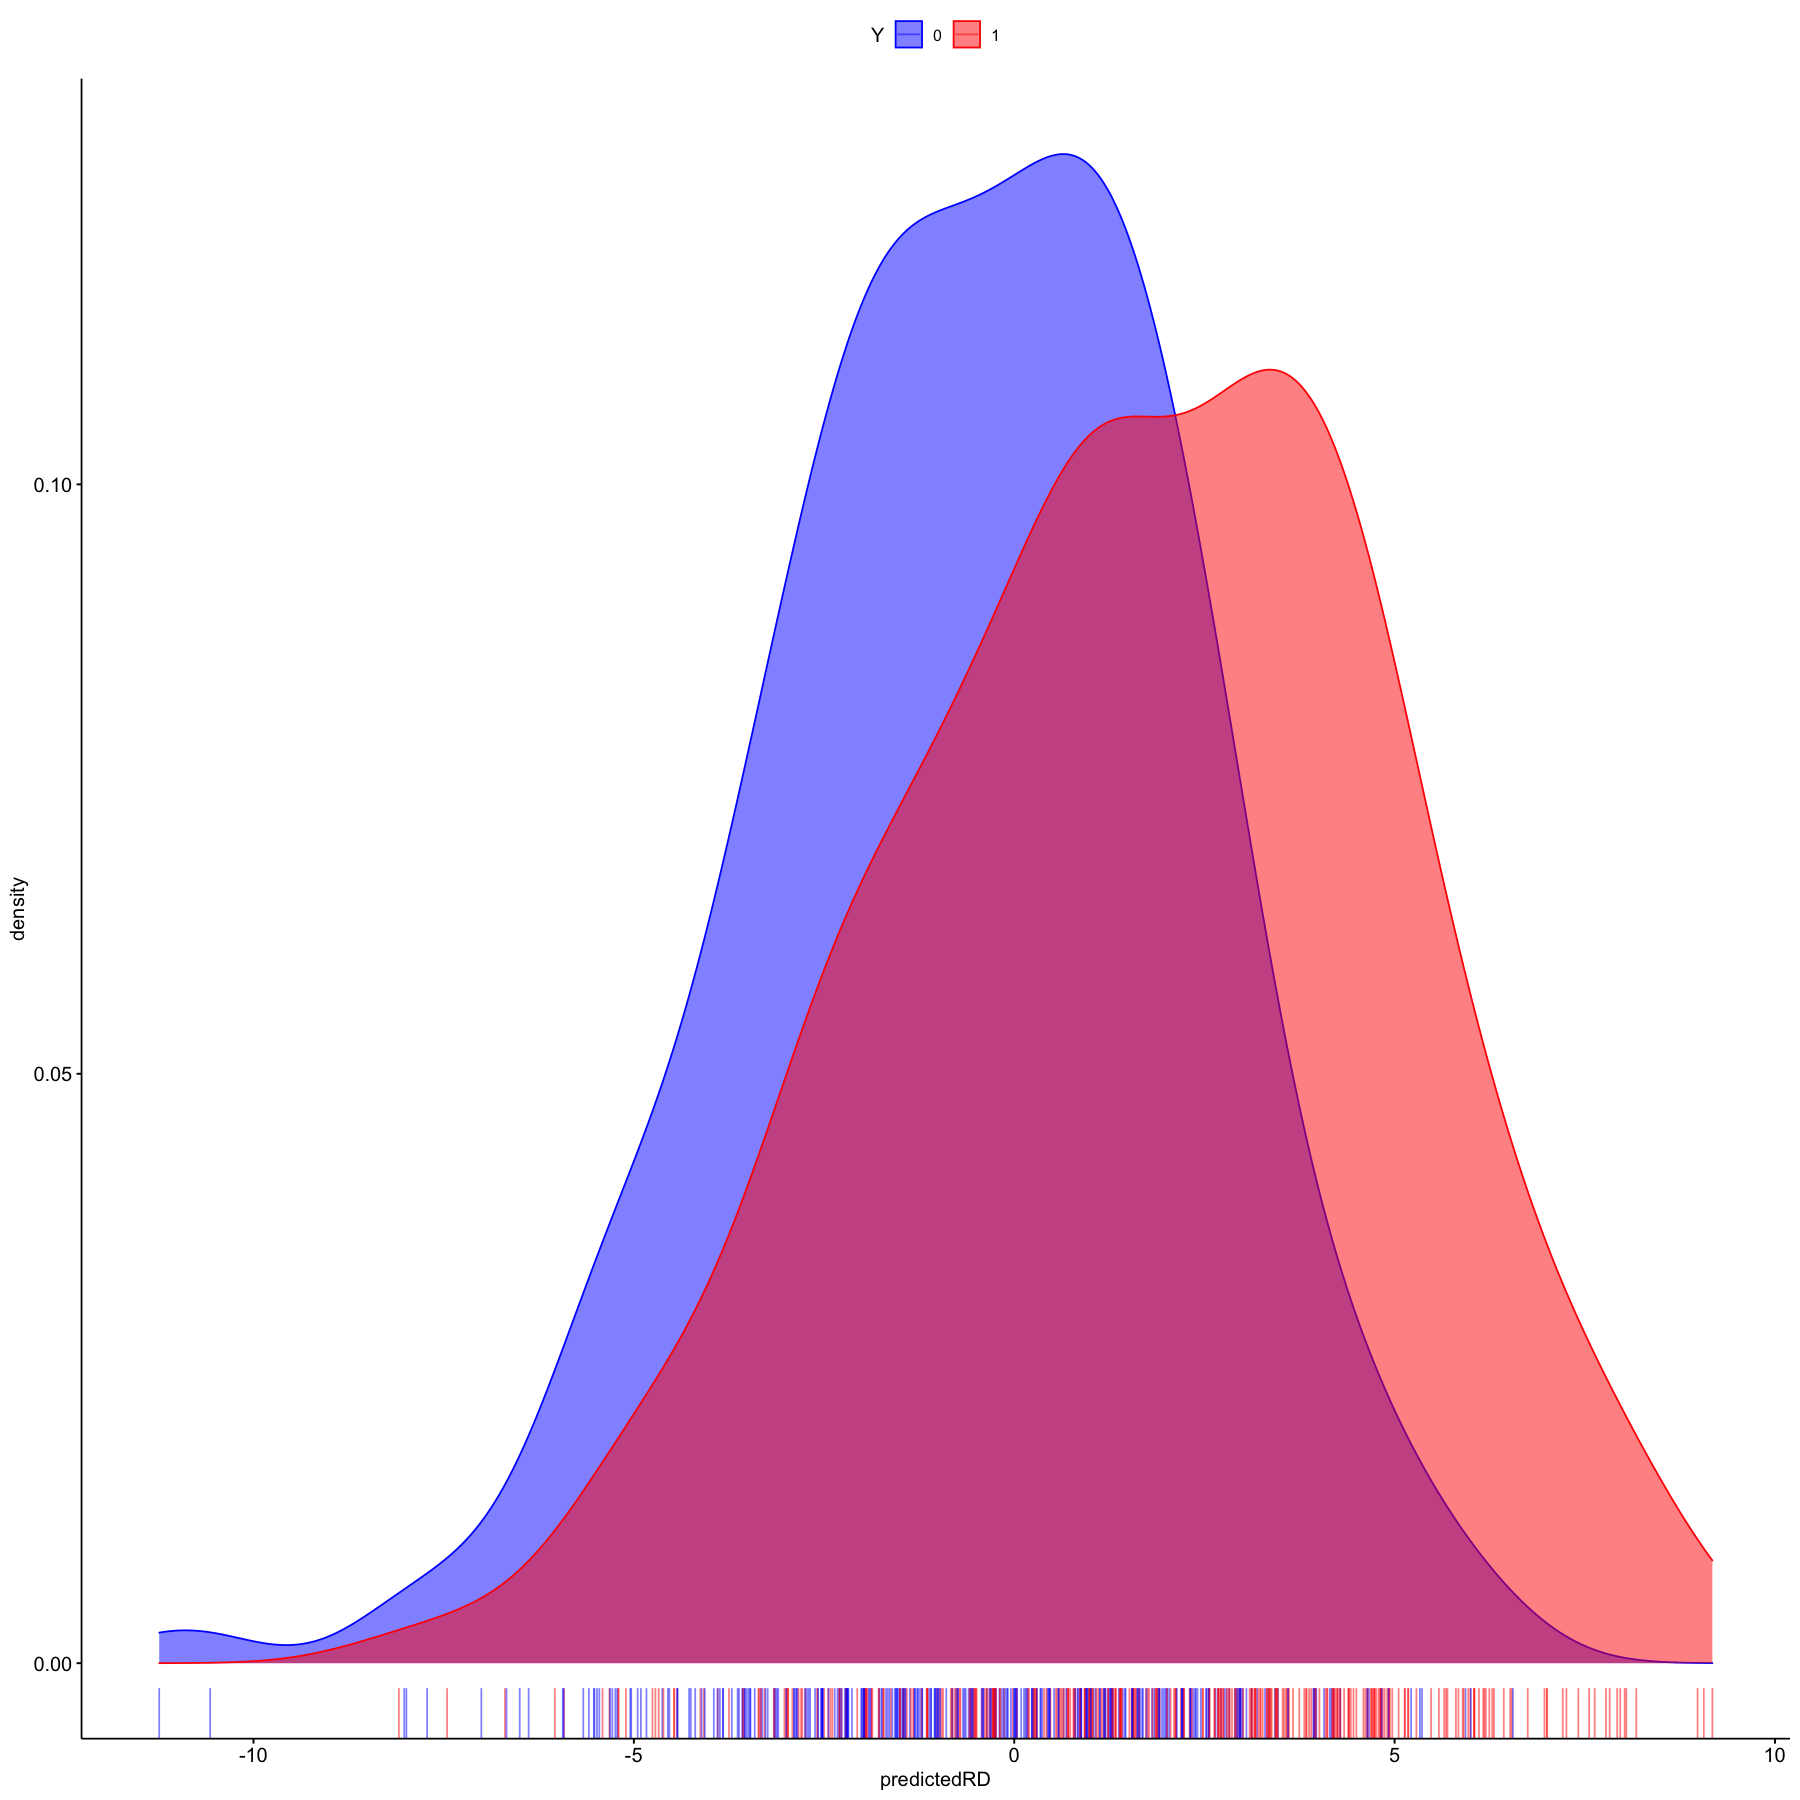

In [24]:
predicted_RD <- data.frame(-1*apply(test.predict$variates,1,risk_distance))
predicted_RD$Y <- as.numeric(as.character(Y))
colnames(predicted_RD) <- c("predictedRD","Y")

predicted_RD$Y <- as.factor(predicted_RD$Y)
ggdensity(predicted_RD, x = "predictedRD",
          rug = TRUE,
          color = "Y", fill = "Y",
          palette = c("blue", "red"))

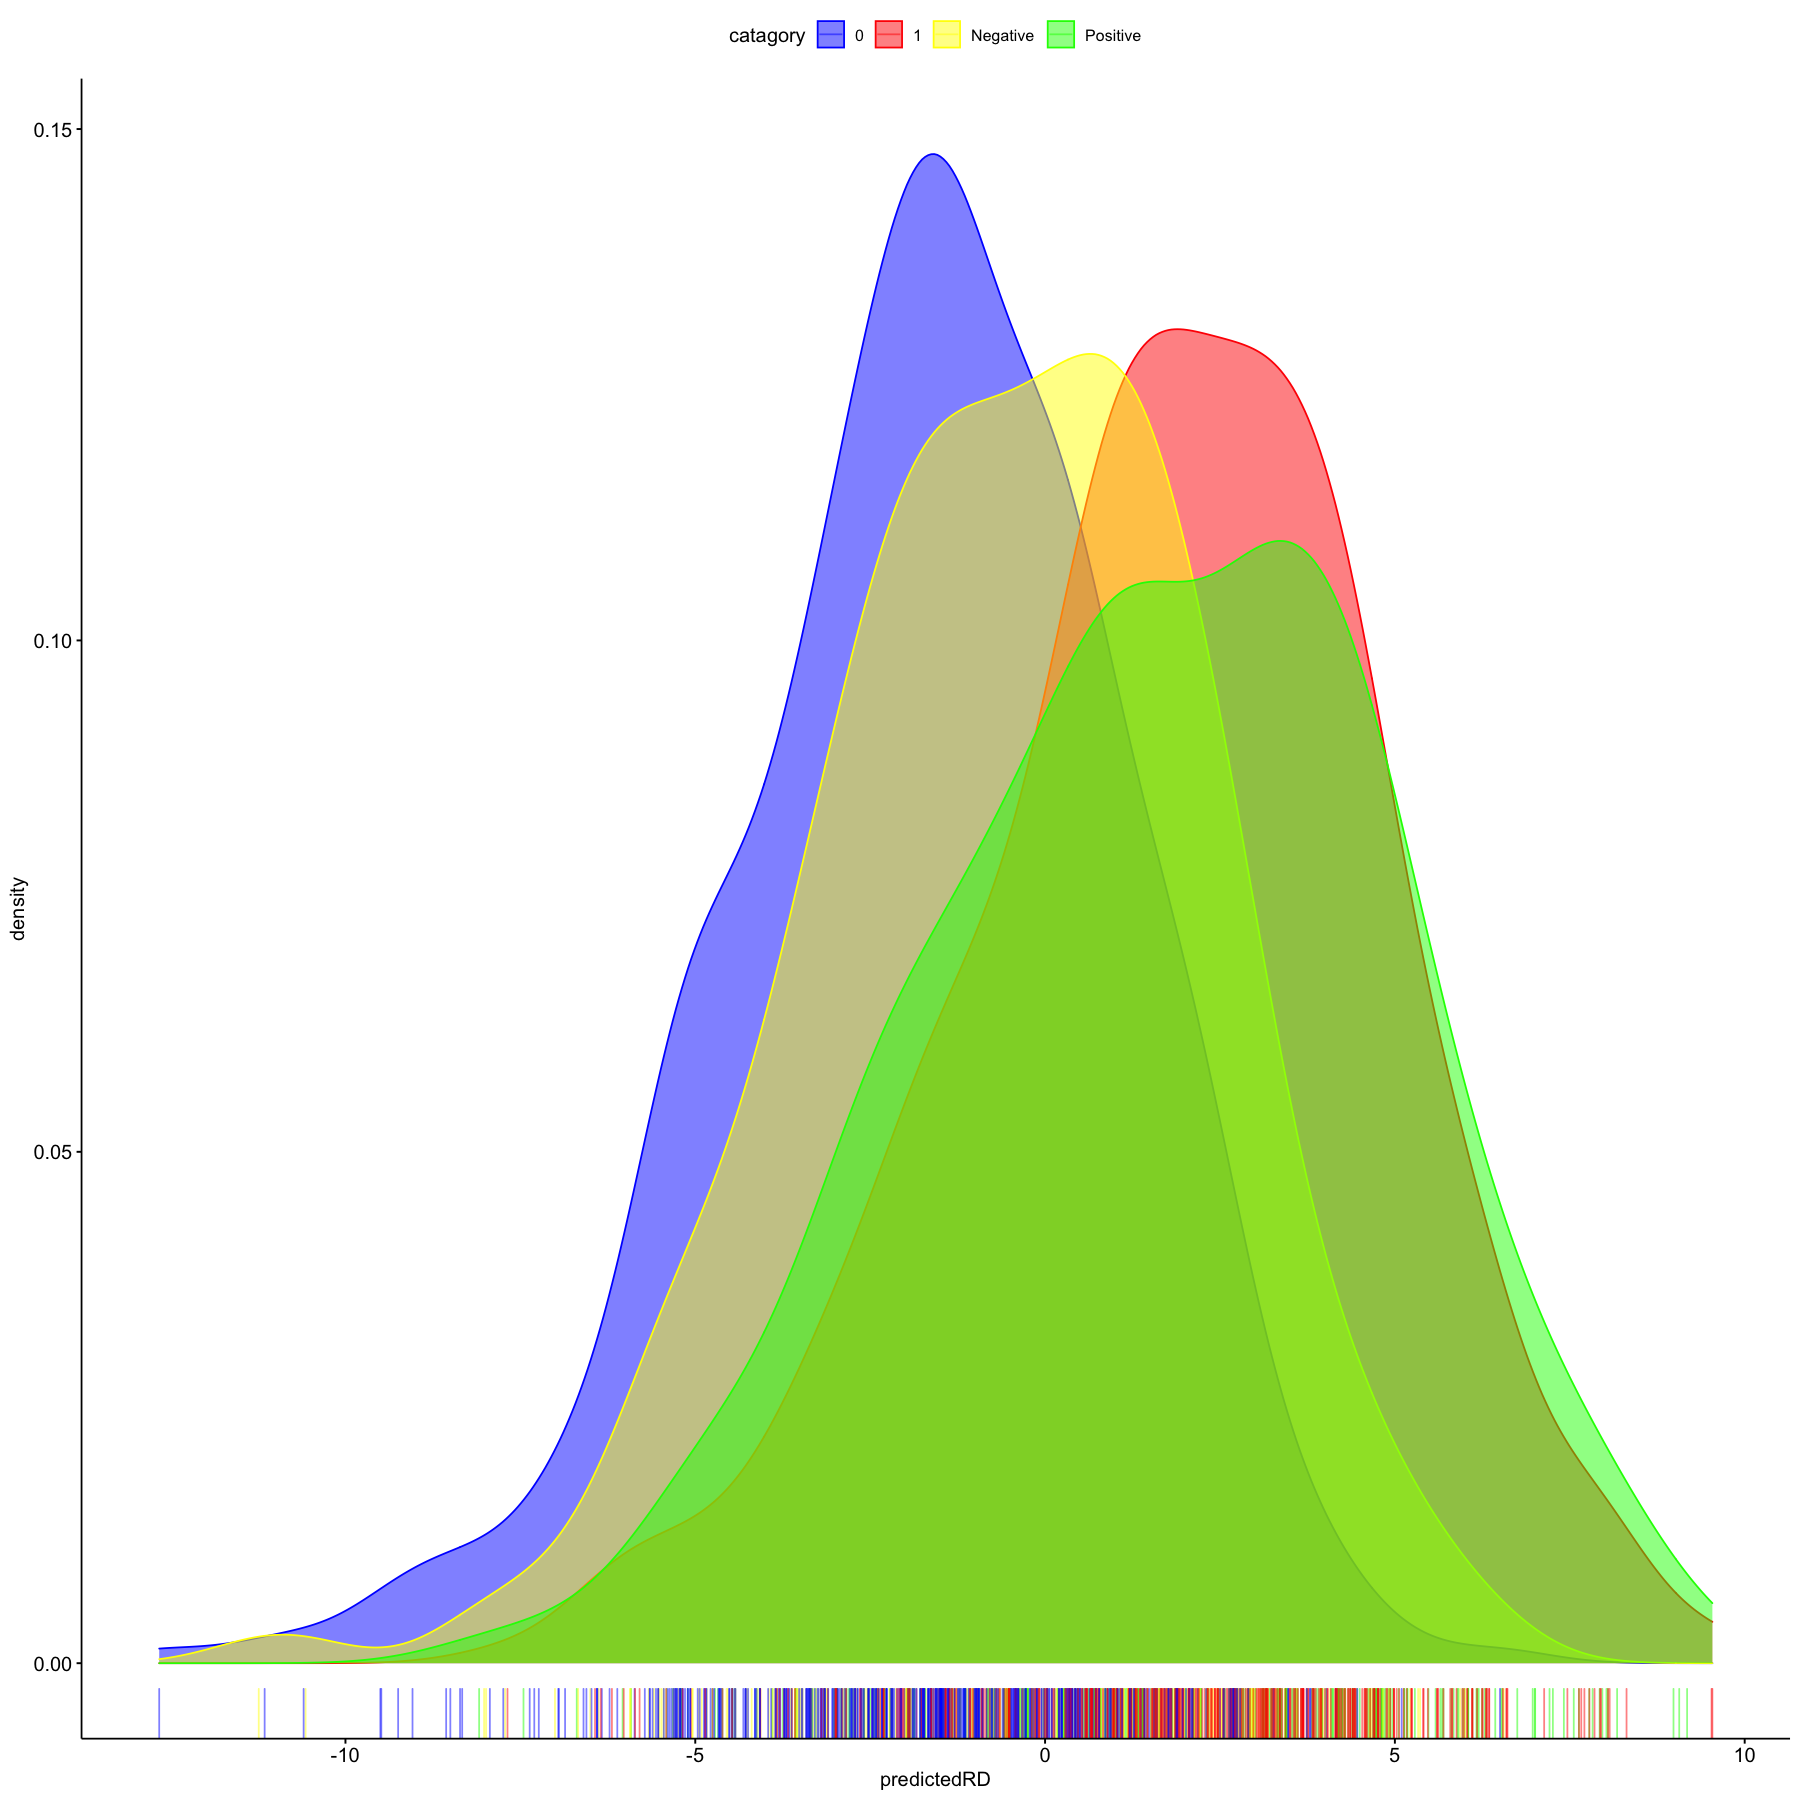

In [25]:
predicted_RD$catagory <- ifelse(predicted_RD$Y==0,"Negative","Positive")
colnames(plot.data) <- c("catagory","predictedRD")

final_RD_table <- rbind(
    predicted_RD[c("predictedRD","catagory")],
    plot.data[c("predictedRD","catagory")]
)
    
ggdensity(final_RD_table, x = "predictedRD",
          rug = TRUE,
          color = "catagory", fill = "catagory",
          palette = c("blue", "red","yellow","green"))

In [26]:
#################################################
PPV <-c()
num_of_predicted_ind <- c()
#stdev <- sd(plot.data[plot.data$catagory==0,]$risk_distance)#increase n
#mean_PRD <- mean(plot.data[plot.data$catagory==0,]$risk_distance)
n_controls <- c()
n_cases <- c()


for(n in seq(1,3,0.5)){
    cutoff <- n*stdev_controls
    cutoff <- mean_controls + cutoff
    
    predicted_RD_cutoff <- predicted_RD[predicted_RD$predictedRD>cutoff,]
    #n_controls_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==0,])[1]
    #n_cases_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1,])[1]
    predicted_RD_cutoff$predicted_Y <- as.numeric(ifelse(predicted_RD_cutoff$predictedRD>cutoff,1,0))
    
    PPV <- c(PPV,
             dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1 & predicted_RD_cutoff$predicted_Y==1 ,])[1]/dim(predicted_RD_cutoff[predicted_RD_cutoff$predicted_Y==1 ,])[1])
    num_of_predicted_ind <- c(num_of_predicted_ind,dim(predicted_RD_cutoff)[1])
}

#plot(x=seq(1,3,0.5),y=PPV,type="o",col="red",xlab="Number of standard deviations from mean")
#plot(x=seq(1,3,0.5),y=num_of_predicted_ind,type="o",col="blue",xlab="Number of standard deviations from mean",ylab="Number of individuals predicted")

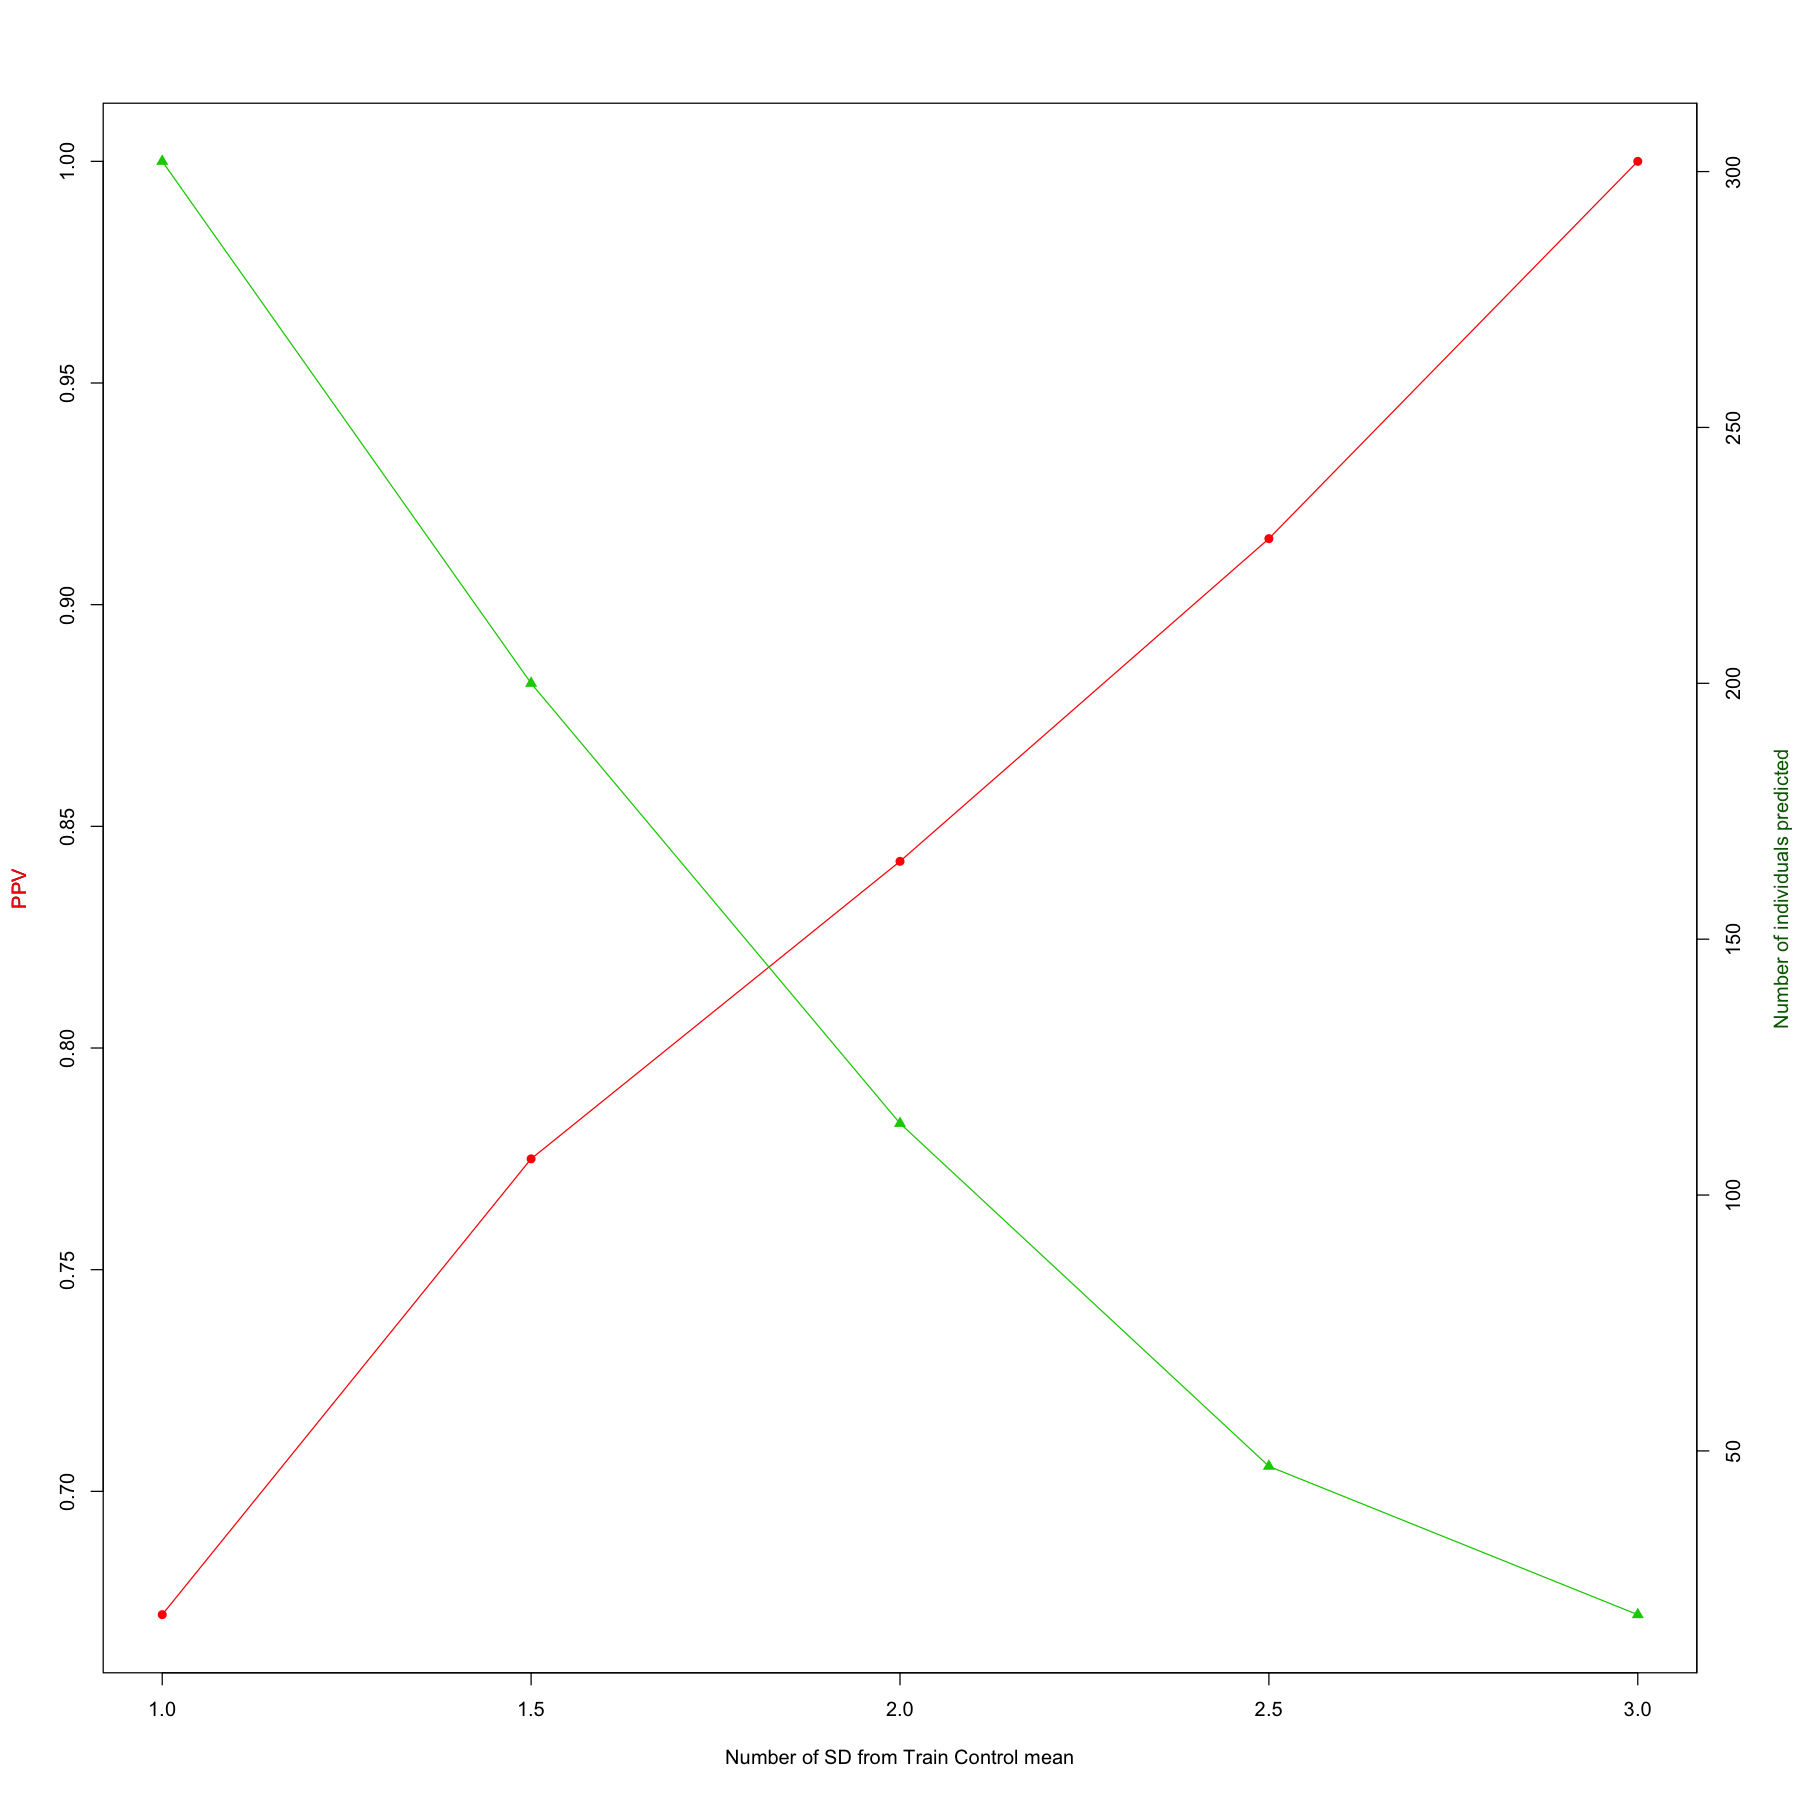

In [27]:
#plot(x=seq(1,3,0.5),y=PPV,type="o",col="red",xlab="Number of standard deviations from mean")
#plot(x=seq(1,3,0.5),y=num_of_predicted_ind,type="o",col="blue",xlab="Number of standard deviations from mean",ylab="Number of individuals predicted")
x=seq(1,3,0.5)
y1=PPV
y2=num_of_predicted_ind
par(mar = c(5, 4, 4, 4) + 0.3)              # Additional space for second y-axis
plot(x, y1, pch = 16, col = 2,type="o",xlab="Number of SD from Train Control mean",ylab="PPV")
mtext("PPV", side = 2, line = 3,col = "red") # Create first plot
par(new = TRUE)                             # Add new plot
plot(x, y2, pch = 17, col = 3,              # Create second plot without axes
     axes = FALSE, xlab = "", ylab = "",type="o")
axis(side = 4, at = pretty(range(y2)))      # Add second axis
mtext("Number of individuals predicted", side = 4, line = 3,col = "darkgreen")             # Add second axis label


In [16]:
write.csv(data.frame(num_of_predicted_ind,PPV),file="./CoRSIV_Probe_PPV_N.csv",row.names=F)

In [17]:
varComp1 <- selectVar(splsda_output_beta,comp = 1)
varComp2 <- selectVar(splsda_output_beta,comp = 2)

selected_C1 <- data.frame(varComp1$value)
selected_C2 <- data.frame(varComp2$value)

selected_C1$probe_id <- row.names(selected_C1)
selected_C2$probe_id <- row.names(selected_C2)

In [18]:
varible_importance <- rbind(selected_C1[order(abs(selected_C1$value.var),decreasing=T),]
,selected_C2[order(abs(selected_C2$value.var),decreasing=T),])

varible_importance$value.var <- abs(varible_importance$value.var)
varible_importance <- varible_importance[order(varible_importance$value.var,decreasing = T),]
write.csv(varible_importance,
          "./model_variables/CoRSIV_Variable_Selection_Model.csv",row.names=F)


Attaching package: ‘caret’


The following objects are masked from ‘package:mixOmics’:

    nearZeroVar, plsda, splsda


Loading required package: randomForest

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: caTools


Attaching package: ‘caTools’


The following objects are masked from ‘package:pracma’:

    combs, trapz




        predicted
observed   1   2
       1 164 158
       2  91 262

[[1]]
[1] 0.6924674

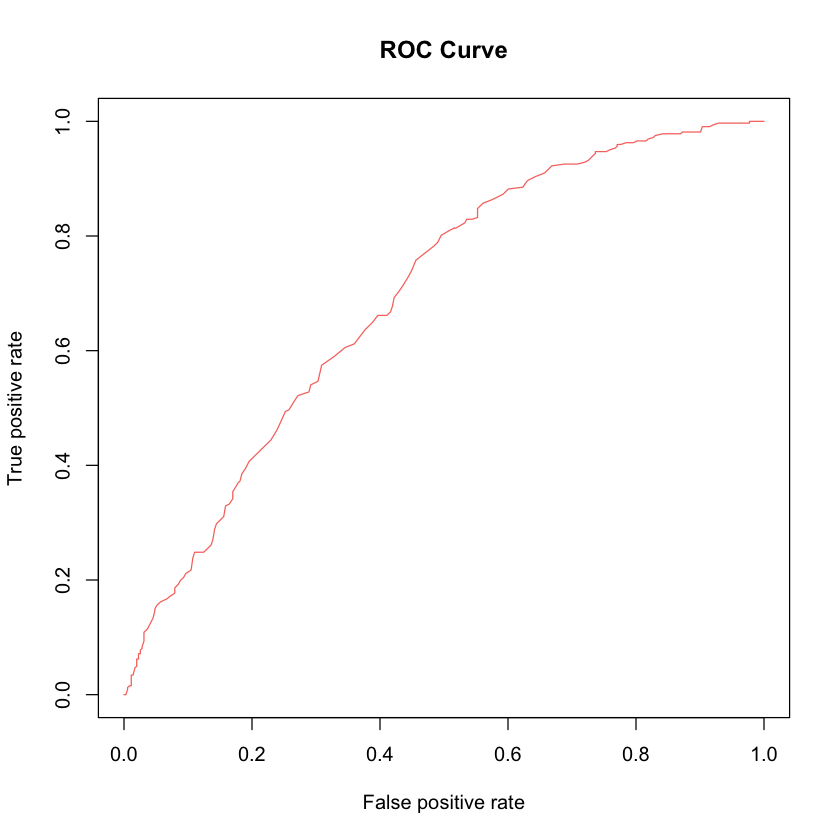

In [19]:
library(caret)
require(randomForest)
library(ROCR)
require(caTools)
selected_var <- as.character(varible_importance$probe_id)
selected_var <- c('status',unique(selected_var))
test <- data.frame(merge(sample_id_phase1,phase1_t,by.x = "id",by.y = "sample.id"))
train <- data.frame(merge(sample_id_phase2,phase2_t,by.x = "id",by.y = "sample.id"))
train <- train[intersect(colnames(train),selected_var)]
test <- test[intersect(colnames(test),selected_var)]
rf_model=randomForest(as.factor(status) ~.,data = train,ntree=500,mtry=50,importance=TRUE)
prediction <- predict(rf_model,subset(test,select = -c(status)))
table(observed = test$status,predicted=prediction)
# Calculate the probability of new observations belonging to each class
# prediction_for_roc_curve will be a matrix with dimensions data_set_size x number_of_classes
prediction_for_roc_curve <- predict(rf_model,subset(test,select = -c(status)),type="prob")
# Use pretty colours:
pretty_colours <- c("#F8766D")
# Specify the different classes 
classes <- levels(as.factor(test$status))
# For each class
i = 1
 # Define which observations belong to class[i]
true_values <- ifelse(test$status==classes[i],2,1)
pred <- prediction(prediction_for_roc_curve[,i],true_values)

perf <- performance(pred, "tpr", "fpr")
plot(perf,main="ROC Curve",col="#F8766D") 
auc.perf <- performance(pred, measure = "auc")
auc.perf@y.values

# Association with PRS

In [28]:
predicted_RD$Basename <- UCL_covariates$Basename
UCL_PRS <- read.csv("./UCL_PRS.csv")
predicted_RD <- merge(predicted_RD,UCL_PRS,by="Basename")

In [31]:
cor.test(predicted_RD$predictedRD,predicted_RD$SCORE,method = "pearson")


	Pearson's product-moment correlation

data:  predicted_RD$predictedRD and predicted_RD$SCORE
t = 5.1437, df = 637, p-value = 3.591e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1240551 0.2730278
sample estimates:
      cor 
0.1996951 


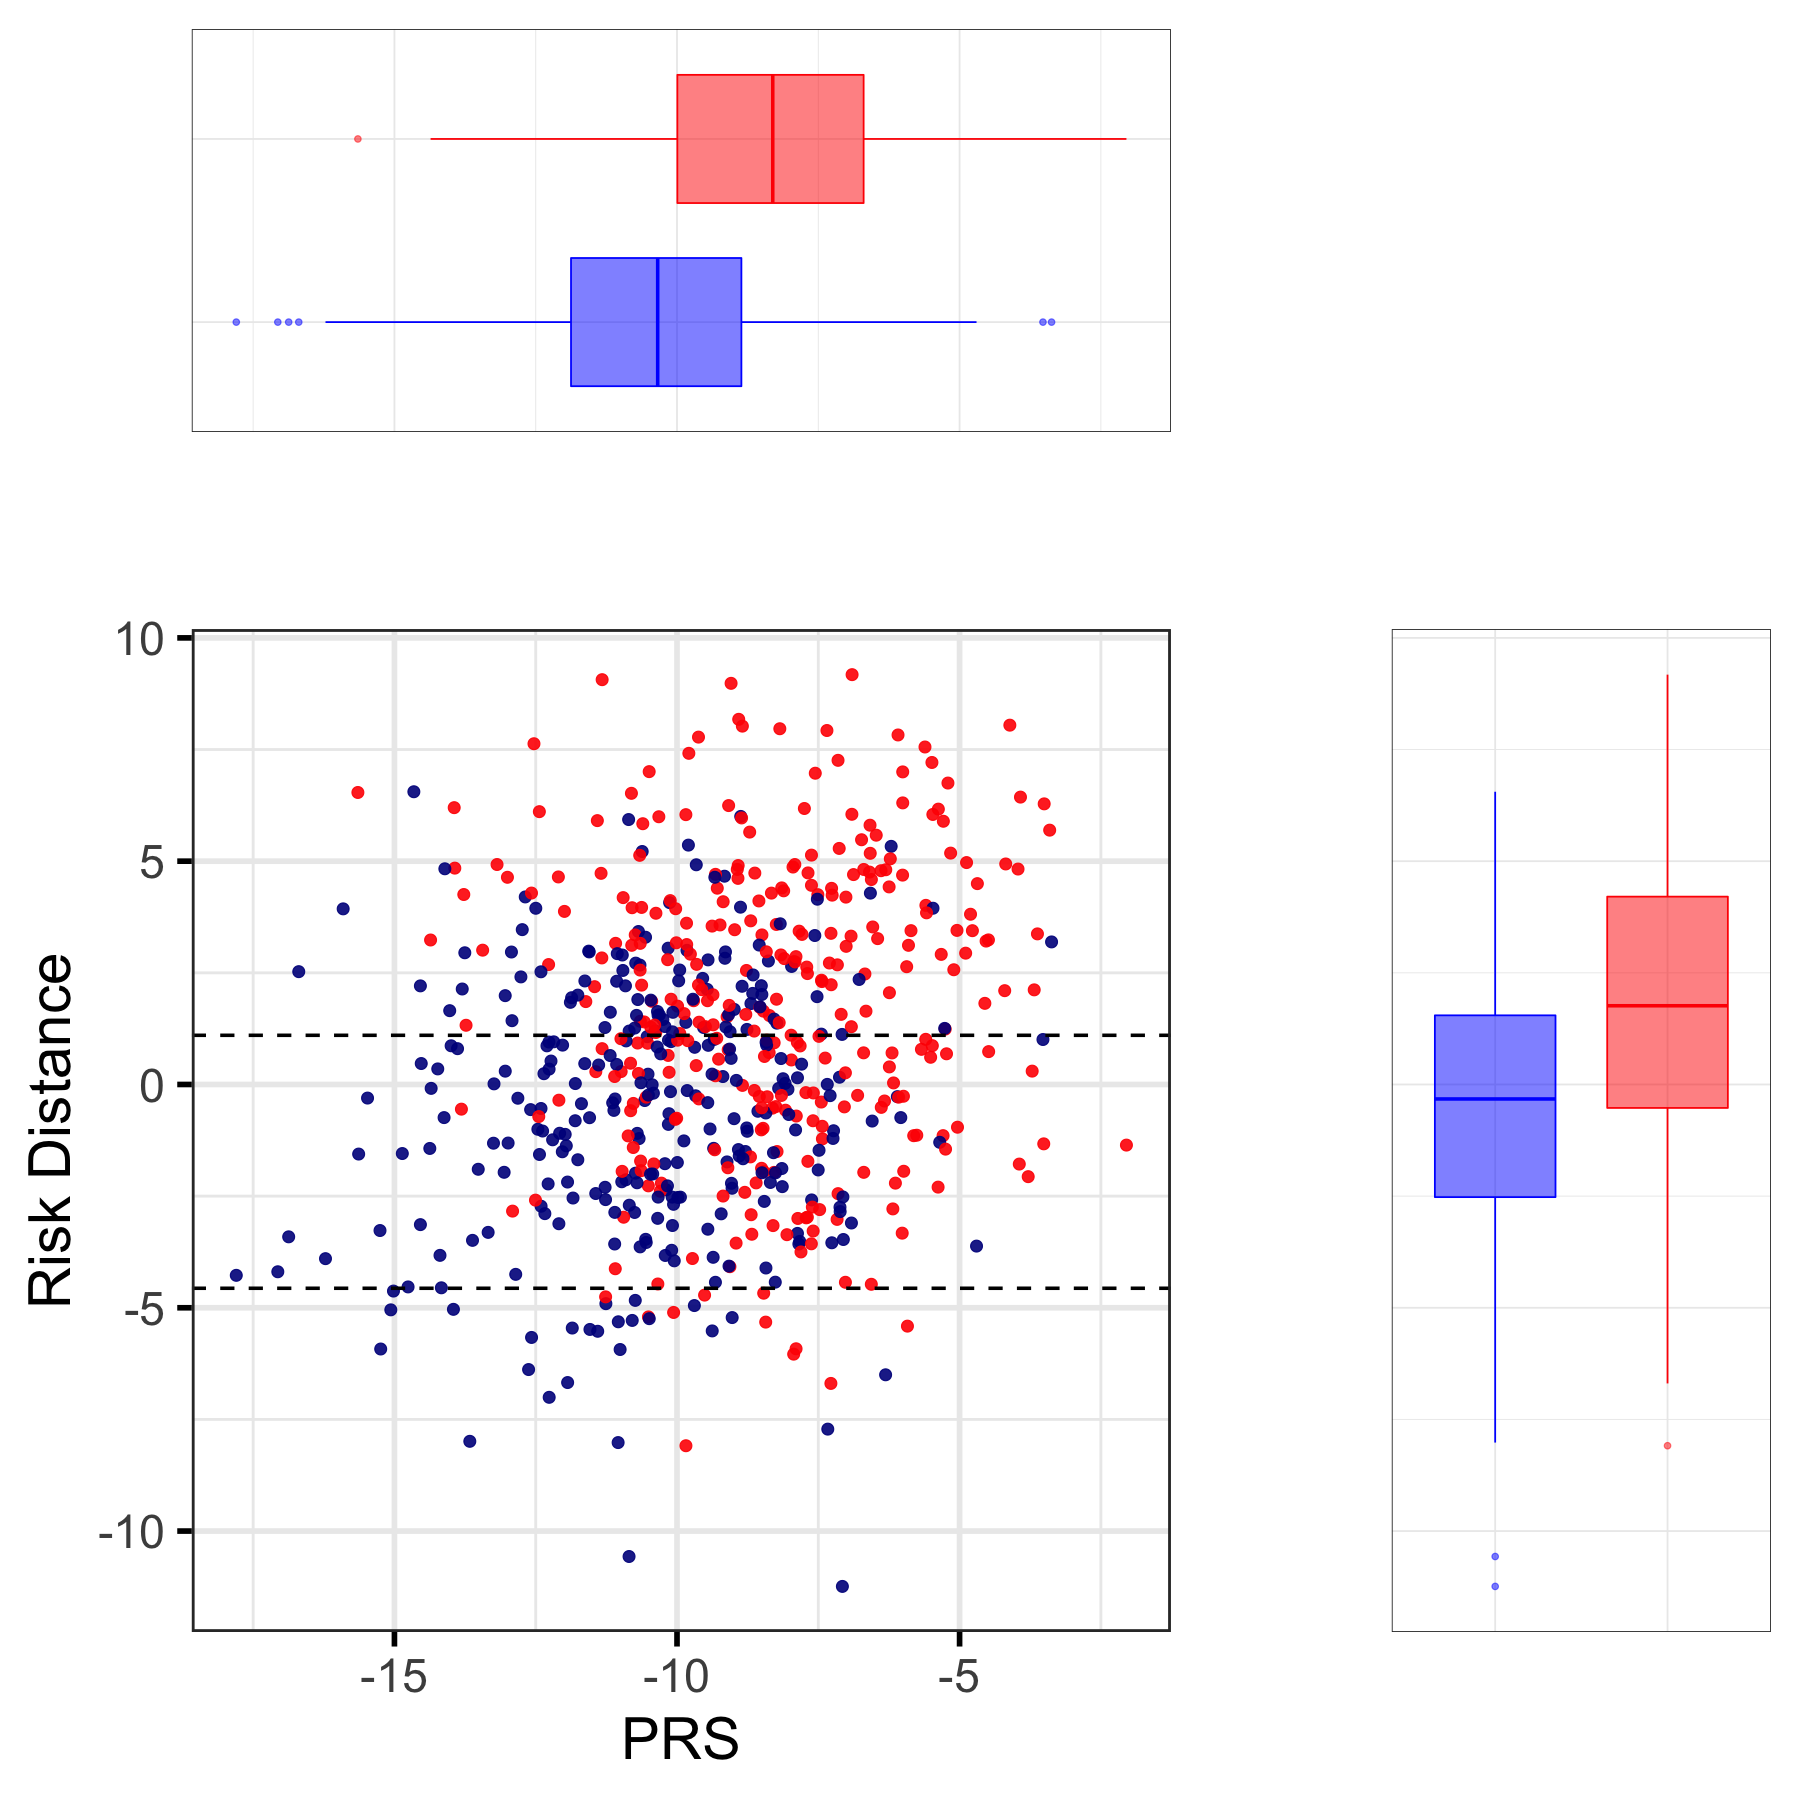

In [30]:
upper <- mean_controls+stdev_controls
lower <- mean_controls-stdev_controls

options(repr.plot.width=15, repr.plot.height=15)
sp <- ggscatter(predicted_RD, x = "SCORE", y = "predictedRD",show.legend.text=TRUE,
                color = "catagory", palette = c("darkblue","red"),
                size = 3, alpha = 0.9, ggtheme = theme_bw(base_size = 35)) + xlab("PRS") +ylab("Risk Distance")
sp <- sp + geom_hline(yintercept=upper,linetype="dashed", color = "black",lwd=1)
sp <- sp + geom_hline(yintercept=lower,linetype="dashed", color = "black",lwd=1)
# Marginal boxplot of x (top panel) and y (right panel)
xplot <- ggboxplot(predicted_RD, x = "catagory", y = "SCORE", 
                   color = "catagory", fill = "catagory", palette = c("blue","red"),
                   alpha = 0.5, ggtheme = theme_bw())+
  rotate()
yplot <- ggboxplot(predicted_RD, x = "catagory", y = "predictedRD",
                   color = "catagory", fill = "catagory", palette = c("blue","red"),
                   alpha = 0.5, ggtheme = theme_bw())
# Cleaning the plots
sp <- sp + rremove("legend")
yplot <- yplot + clean_theme() + rremove("legend")
xplot <- xplot + clean_theme() + rremove("legend")
# Arranging the plot using cowplot

plot_grid(xplot, NULL, sp, yplot, ncol = 2, align = "hv", 
          rel_widths = c(2, 1), rel_heights = c(1, 2))

In [32]:
fit.totaleffect=glm(Y~SCORE,predicted_RD,family = "binomial")
summary(fit.totaleffect)

fit.mediator=lm(predictedRD~SCORE,data=predicted_RD)
summary(fit.mediator)

fit.dv=glm(Y~SCORE+predictedRD,data=predicted_RD,family = "binomial")
summary(fit.dv)

summary(mediate(fit.mediator, fit.dv, treat='SCORE', mediator='predictedRD',robustSE = TRUE, sims = 2000))



Call:
glm(formula = Y ~ SCORE, family = "binomial", data = predicted_RD)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2390  -1.0336   0.4797   0.9938   2.2224  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.74088    0.39640   9.437   <2e-16 ***
SCORE        0.39125    0.04129   9.477   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 884.86  on 638  degrees of freedom
Residual deviance: 766.83  on 637  degrees of freedom
AIC: 770.83

Number of Fisher Scoring iterations: 3



Call:
lm(formula = predictedRD ~ SCORE, data = predicted_RD)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.4419  -2.3613   0.1007   2.2525   8.9625 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.03434    0.48748   6.225 8.76e-10 ***
SCORE        0.25895    0.05034   5.144 3.59e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.247 on 637 degrees of freedom
Multiple R-squared:  0.03988,	Adjusted R-squared:  0.03837 
F-statistic: 26.46 on 1 and 637 DF,  p-value: 3.591e-07



Call:
glm(formula = Y ~ SCORE + predictedRD, family = "binomial", data = predicted_RD)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4479  -0.9649   0.3380   0.9529   2.0687  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.52985    0.41907   8.423  < 2e-16 ***
SCORE        0.38125    0.04359   8.746  < 2e-16 ***
predictedRD  0.21955    0.03114   7.050 1.78e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 884.86  on 638  degrees of freedom
Residual deviance: 709.56  on 636  degrees of freedom
AIC: 715.56

Number of Fisher Scoring iterations: 4



Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

                         Estimate 95% CI Lower 95% CI Upper p-value    
ACME (control)           0.001063     0.000422         0.00  <2e-16 ***
ACME (treated)           0.000754     0.000270         0.00  <2e-16 ***
ADE (control)            0.006071     0.003025         0.01  <2e-16 ***
ADE (treated)            0.005762     0.002808         0.01  <2e-16 ***
Total Effect             0.006825     0.003341         0.01  <2e-16 ***
Prop. Mediated (control) 0.153453     0.090354         0.23  <2e-16 ***
Prop. Mediated (treated) 0.105844     0.061137         0.16  <2e-16 ***
ACME (average)           0.000909     0.000347         0.00  <2e-16 ***
ADE (average)            0.005916     0.002910         0.01  <2e-16 ***
Prop. Mediated (average) 0.129648     0.075712         0.19  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 639 


Simulations: 2000 



Call:
glm(formula = Y ~ SCORE, family = "binomial", data = temp_pred_RD)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3382  -1.1357   0.5984   0.9134   1.9635  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.88546    0.55640   6.983 2.89e-12 ***
SCORE        0.36147    0.05681   6.362 1.99e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 428.25  on 322  degrees of freedom
Residual deviance: 377.15  on 321  degrees of freedom
AIC: 381.15

Number of Fisher Scoring iterations: 3



Call:
lm(formula = predictedRD ~ SCORE, data = temp_pred_RD)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.373  -0.815   0.418   1.959   7.351 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.49664    0.71311   7.708 1.61e-13 ***
SCORE        0.33412    0.07522   4.442 1.23e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.452 on 321 degrees of freedom
Multiple R-squared:  0.0579,	Adjusted R-squared:  0.05497 
F-statistic: 19.73 on 1 and 321 DF,  p-value: 1.229e-05



Call:
glm(formula = Y ~ SCORE + predictedRD, family = "binomial", data = temp_pred_RD)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3429  -1.0312   0.4855   0.8444   2.0368  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.08978    0.59693   5.176 2.27e-07 ***
SCORE        0.33027    0.05973   5.530 3.21e-08 ***
predictedRD  0.21997    0.04352   5.054 4.32e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 428.25  on 322  degrees of freedom
Residual deviance: 344.90  on 320  degrees of freedom
AIC: 350.9

Number of Fisher Scoring iterations: 4



Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

                         Estimate 95% CI Lower 95% CI Upper p-value    
ACME (control)           0.001366     0.000322         0.00  <2e-16 ***
ACME (treated)           0.001041     0.000217         0.00  <2e-16 ***
ADE (control)            0.005176     0.001950         0.01  <2e-16 ***
ADE (treated)            0.004850     0.001788         0.01  <2e-16 ***
Total Effect             0.006216     0.002161         0.01  <2e-16 ***
Prop. Mediated (control) 0.209435     0.093338         0.34  <2e-16 ***
Prop. Mediated (treated) 0.151187     0.063117         0.28  <2e-16 ***
ACME (average)           0.001203     0.000271         0.00  <2e-16 ***
ADE (average)            0.005013     0.001882         0.01  <2e-16 ***
Prop. Mediated (average) 0.180311     0.078013         0.31  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 323 


Simulations: 1000 



Call:
glm(formula = Y ~ predictedRD, family = "binomial", data = temp_pred_RD)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8629  -1.2909   0.6891   0.9000   2.1038  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.08734    0.16293  -0.536    0.592    
predictedRD  0.24846    0.04229   5.875 4.24e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 428.25  on 322  degrees of freedom
Residual deviance: 381.23  on 321  degrees of freedom
AIC: 385.23

Number of Fisher Scoring iterations: 4


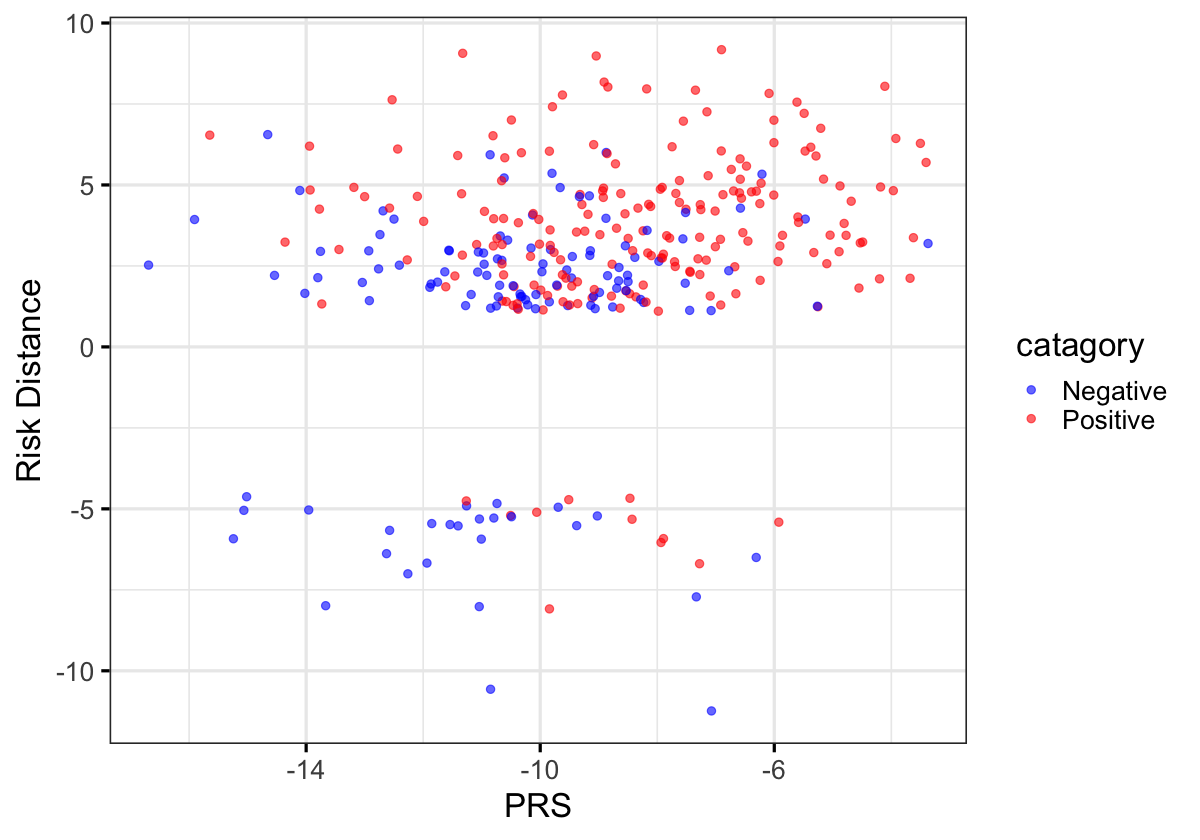

In [33]:
pred_RD_lower <- predicted_RD[predicted_RD$predictedRD <= lower ,]
pred_RD_upper <- predicted_RD[ upper <= predicted_RD$predictedRD  ,]

temp_pred_RD <- rbind(pred_RD_lower,pred_RD_upper)
options(repr.plot.width=10, repr.plot.height=7)
ggscatter(temp_pred_RD, x = "SCORE", y = "predictedRD",
                color = "catagory", palette = c("blue","red"),
                size = 2, alpha = 0.6, ggtheme = theme_bw(base_size = 20)) + xlab("PRS") +ylab("Risk Distance")

fit.totaleffect=glm(Y~SCORE,temp_pred_RD,family = "binomial")
summary(fit.totaleffect)
fit.mediator=lm(predictedRD~SCORE,data=temp_pred_RD)
summary(fit.mediator)
fit.dv=glm(Y~SCORE+predictedRD,data=temp_pred_RD,family = "binomial")
summary(fit.dv)
summary(mediate(fit.mediator, fit.dv, treat='SCORE', mediator='predictedRD',robustSE = TRUE, sims = 1000))
midiation_results <- mediate(fit.mediator, fit.dv, treat='SCORE', mediator='predictedRD',robustSE = TRUE, sims = 1000)
fit.mediator=glm(Y~predictedRD,data=temp_pred_RD,family = "binomial")
summary(fit.mediator)

In [34]:

plot.data$Basename <- Aberdeen_covariates$Basename

In [35]:
Aber_PRS <- read.csv("./Aber_PRS.csv")

In [36]:
plot.data <- merge(plot.data,Aber_PRS,by="Basename")

In [38]:
cor(plot.data$predictedRD,plot.data$SCORE)

[1] -0.01597618

# Testing on brain DNA methylation data

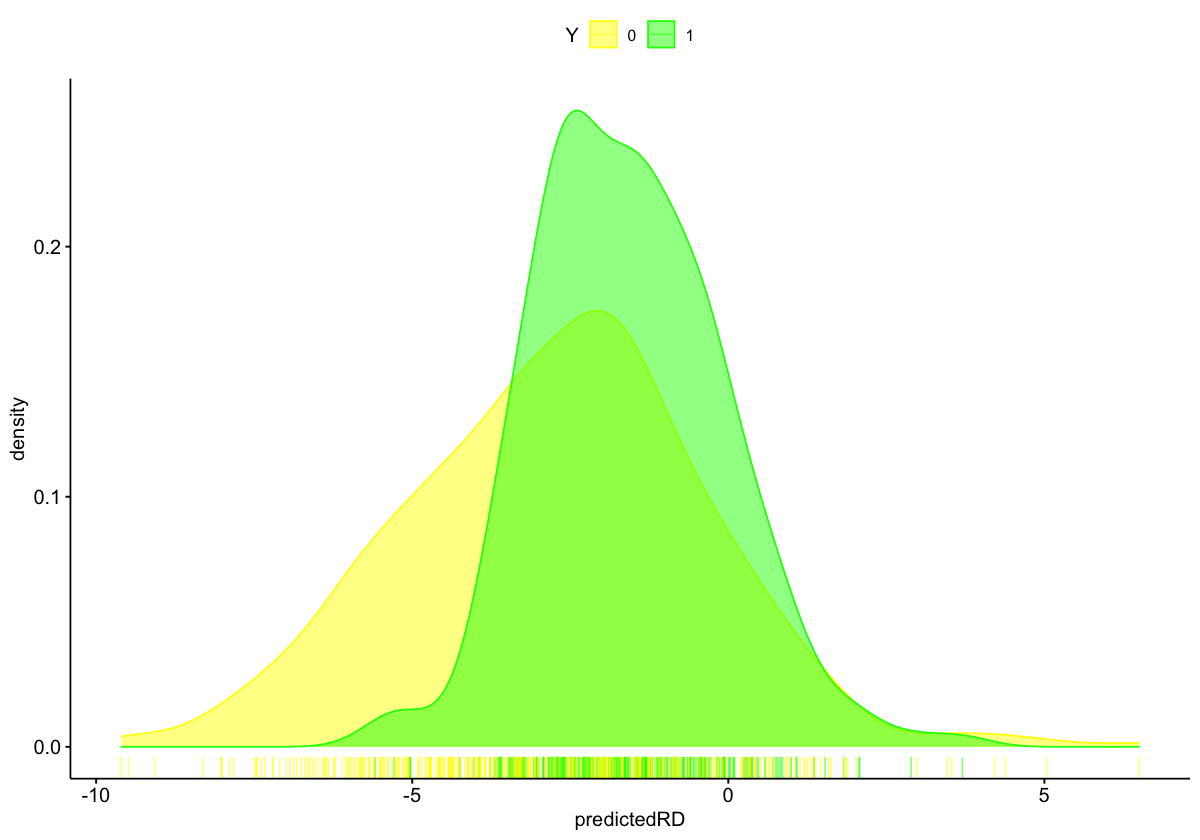

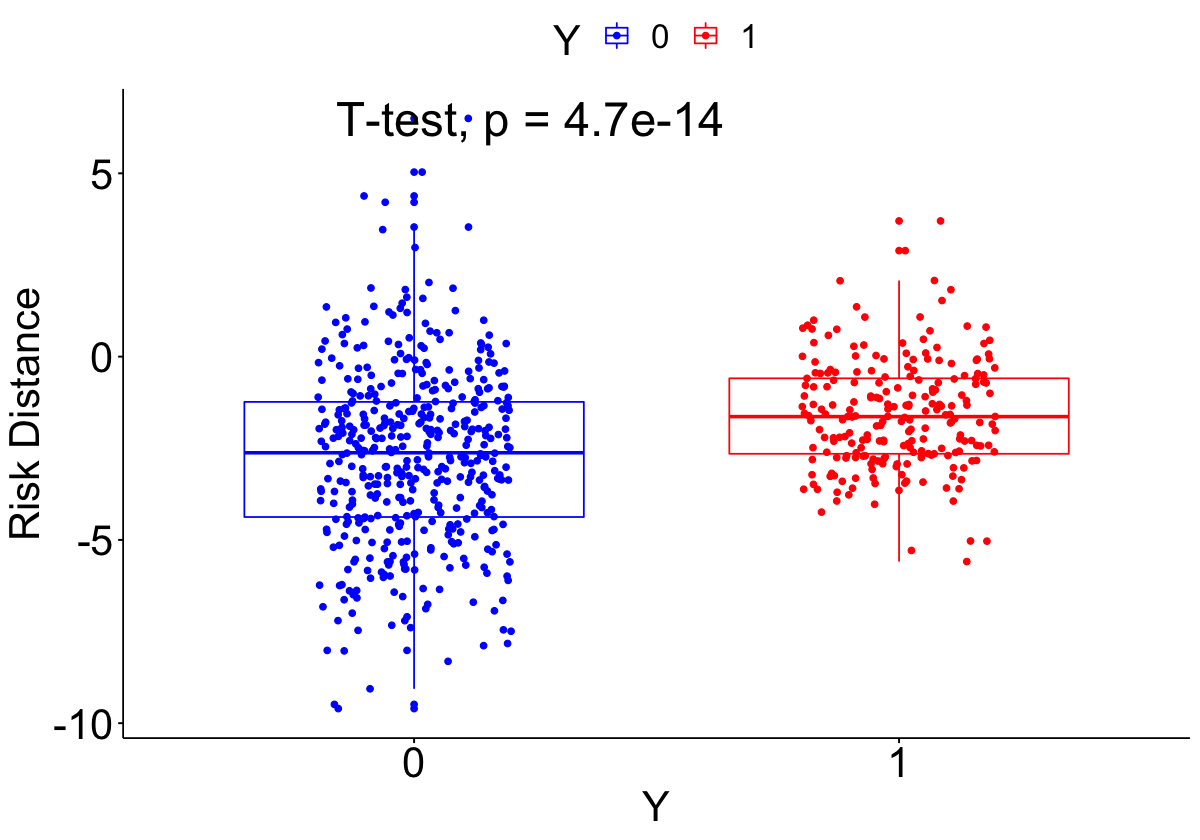

In [39]:
test <- read.csv("./GEO/GSE74193.csv")
test$sample_id <- NULL

Y <- test$status
test$status <- NULL

test.predict <- predict(splsda_output_beta,test[colnames(splsda_output_beta$X)])


predicted_RD <- data.frame(-1*apply(test.predict$variates,1,risk_distance))
predicted_RD$Y <- as.numeric(as.character(Y))
colnames(predicted_RD) <- c("predictedRD","Y")

predicted_RD$Y <- as.factor(predicted_RD$Y)
ggdensity(predicted_RD, x = "predictedRD",
          rug = TRUE,
          color = "Y", fill = "Y",
          palette = c("yellow", "green"))

p <- ggboxplot(predicted_RD, x = "Y", y = "predictedRD",add = "jitter",
  color = "Y", palette = c("blue", "red"))

#  Add p-value
p + stat_compare_means(method = "t.test",size=10) + theme(text = element_text(size=25))+ylab("Risk Distance")
